In [263]:
from collections.abc import Iterable
import os

from datetime import datetime, timedelta
from dateutil import tz
from hdmf.backends.hdf5.h5_utils import H5DataIO
from hdmf.container import Container
from hdmf.data_utils import DataChunkIterator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pynwb import load_namespaces, get_class, register_class, NWBFile, TimeSeries, NWBHDF5IO
from pynwb.file import MultiContainerInterface, NWBContainer, Device, Subject
from pynwb.ophys import ImageSeries, OnePhotonSeries, OpticalChannel, ImageSegmentation, PlaneSegmentation, Fluorescence, DfOverF, CorrectedImageStack, MotionCorrection, RoiResponseSeries, ImagingPlane
from pynwb.core import NWBDataInterface
from pynwb.epoch import TimeIntervals
from pynwb.behavior import SpatialSeries, Position
from pynwb.image import ImageSeries
import scipy.io as sio
import seaborn as sns
import skimage.io as skio
from sklearn.neighbors import NearestNeighbors
from tifffile import TiffFile

from atlas import loadmat, NPAtlas
from process_file import get_nwb_neurons, get_dataset_neurons, combine_datasets, get_pairings, get_color_discrim, get_neur_nums
from stats import get_summary_stats, analyze_pairs
from visualization import plot_num_heatmap, plot_std_heatmap, plot_summary_stats, plot_color_discrim

# ndx_mulitchannel_volume is the novel NWB extension for multichannel optophysiology in C. elegans
from ndx_multichannel_volume import CElegansSubject, OpticalChannelReferences, OpticalChannelPlus, ImagingVolume, VolumeSegmentation, MultiChannelVolume, MultiChannelVolumeSeries

In [264]:
import os


## Figure 1: NWB extension for optophysiology in C. elegans

This will probably be an illustrator created visual which shows all of the different objects that go into the NWB file and how they interplay with each other. Similar to how it is shown in the NWB tutorails

## Figure 2: Software pipelines for working with NWB

## Table 1: Summary of collected datasetes

Columns will be: source paper, lab, number of worms, NP/GCaMP/both, average num segmented neurons, average num ID labels, notes

## Figure 3: Summary statistics of datasets

Unprocessed data from each dataset run through NP software, box-whisker plot, plus additional box for performance of consolidated dataset

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:53

   seg   ID  labels
0  183  183  Yemini
1  166  164  Yemini
2  178  175  Yemini
3  184  180  Yemini
4  180  175  Yemini


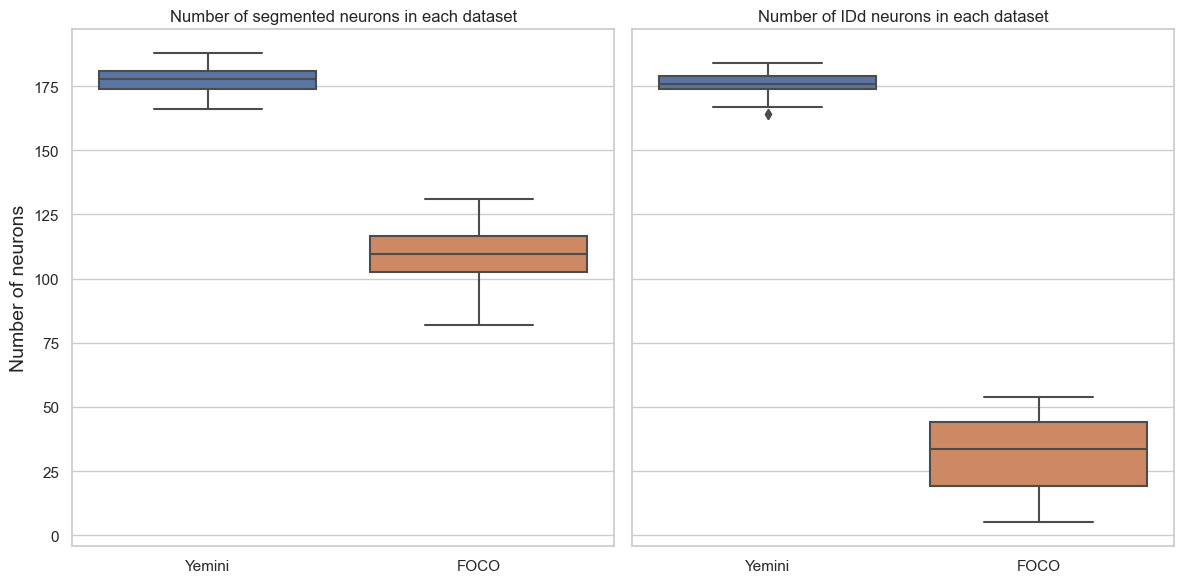

In [265]:
'''
Call get_dataset_neurons for each data source folder that you want to process. Returns a df with all blobs across
all files in the source folder, with an additional column to show which file that blob came from

Call get_summary_stats and plot_summary_stats to get the number of segmented and IDd neurons by dataset and plot
on bar plot
'''

Yem_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/Yemini_NWB')
FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_Ray')

num_seg_yem, num_ID_yem = get_summary_stats(Yem_dataset)
num_seg_FOCO, num_ID_FOCO = get_summary_stats(FOCO_dataset)

plot_summary_stats([num_seg_yem, num_seg_FOCO], [num_ID_yem, num_ID_FOCO], ['Yemini', 'FOCO'])

In [266]:
Yem_dataset['20190924_01']

,x,y,z,R,G,B,xr,yr,zr,ID
0,2,141,11,397,206,78,0.533333,37.600000,16.5,IL2VL
1,8,50,4,982,628,234,2.133333,13.333333,6.0,IL2DR
2,32,123,3,1334,164,916,8.533333,32.800000,4.5,I2R
3,33,114,13,827,172,623,8.800000,30.400000,19.5,I2L
4,37,109,11,156,209,175,9.866667,29.066667,16.5,MCL
...,...,...,...,...,...,...,...,...,...,...
176,443,218,5,1877,93,4095,118.133333,58.133333,7.5,RIGR
177,459,227,5,1000,4095,331,122.400000,60.533333,7.5,DA1
178,468,232,7,1416,1497,1267,124.800000,61.866667,10.5,DB1
179,482,237,8,1276,0,3587,128.533333,63.200000,12.0,RIGL


In [267]:
'''
Pass datasets generated by get_dataset_neurons to combine datasetes. Can pass any number of datasets as 
list elements. This will preserve which file each neuron comes from but not which original folder
'''

tot_dataset = combine_datasets([Yem_dataset, FOCO_dataset])
print(tot_dataset.keys())

dict_keys(['20190928_08', '20190929_02', '20190929_03', '20190925_01', '20191030_07', '20190925_04', '20191030_03', '20190929_05', '20190929_07', '20190929_06', '20191104_10', '20191104_08', '20190924_01', '20190928_01', '20190928_03', '20190924_03', '20190924_02', '20190928_13', '20190928_07', '20190928_11', '20190928_05', '20230412-20-15-17', '20230506-14-24-57', '20230510-13-25-46', '20230322-22-43-03', '20221106-21-47-31', '20230506-12-56-00', '20221106-21-00-09', '20230322-20-16-50', '20221028-18-48-00', '20230506-13-32-08', '20230510-16-36-46', '20230506-15-33-51', '20230510-15-49-47', '20221215-20-02-49', '20230322-21-41-10', '20221106-21-23-19', '20230506-15-01-45', '20230510-12-53-34', '20221215-22-02-55', '20230322-18-57-04'])


In [268]:
pair_yem = get_pairings(Yem_dataset)

In [269]:
pair_FOCO = get_pairings(FOCO_dataset)

In [270]:
pair_tot = get_pairings(tot_dataset)

In [271]:
atlas = NPAtlas(atlas_file = '/Users/danielysprague/foco_lab/data/atlases/atlas_xx_rgb.mat', ganglia ='/Users/danielysprague/foco_lab/data/atlases/neuron_ganglia.csv' )
atlas.create_dictionary()
df = atlas.get_df()

In [272]:
def get_neur_nums(tot_dataset, atlas):

    neur_IDs = atlas.df['ID']

    num_datasets = len(tot_dataset.keys())
    neurons = {k:0 for k in neur_IDs}

    for dataset in tot_dataset.keys():
        blobs = tot_dataset[dataset]

        for i, row in blobs.iterrows():
            ID = row['ID']
            if ID == '':
                continue

            if not ID in neurons:
                neurons[ID] = 1

            else:
                neurons[ID] += 1

    return neurons, num_datasets

def plot_neur_nums(neurons, num_datasets, atlas):

    neur_df = atlas.df[['ID', 'ganglion']]

    dict_df = pd.DataFrame(list(neurons.items()), columns = ['ID', 'num'])
    dict_df['frac'] = dict_df['num']/num_datasets
 
    merged = pd.merge(neur_df, dict_df, on='ID') #this will preserve the order of neurons from neur_df which is sorted by ganglion and then distance along x axis

    sns.set(style='whitegrid')

    plt.figure(figsize=(12,8))
    sns.barplot(x='ID', y='frac', hue='ganglion', data=merged)

    plt.xlabel('Neuron IDs')
    plt.ylabel('Fraction of datasets with ground truth labeled neuron')

    plt.xticks(rotation=60, ha='right', fontsize=6)

    bar_width = 1

    for patch in plt.gca().patches:
        current_width = patch.get_width()
        diff = current_width - bar_width

        # Change the bar width
        patch.set_width(bar_width)

        # Recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

    # Show the plot
    plt.legend(title='ganglion', loc='upper right')

    plt.show()




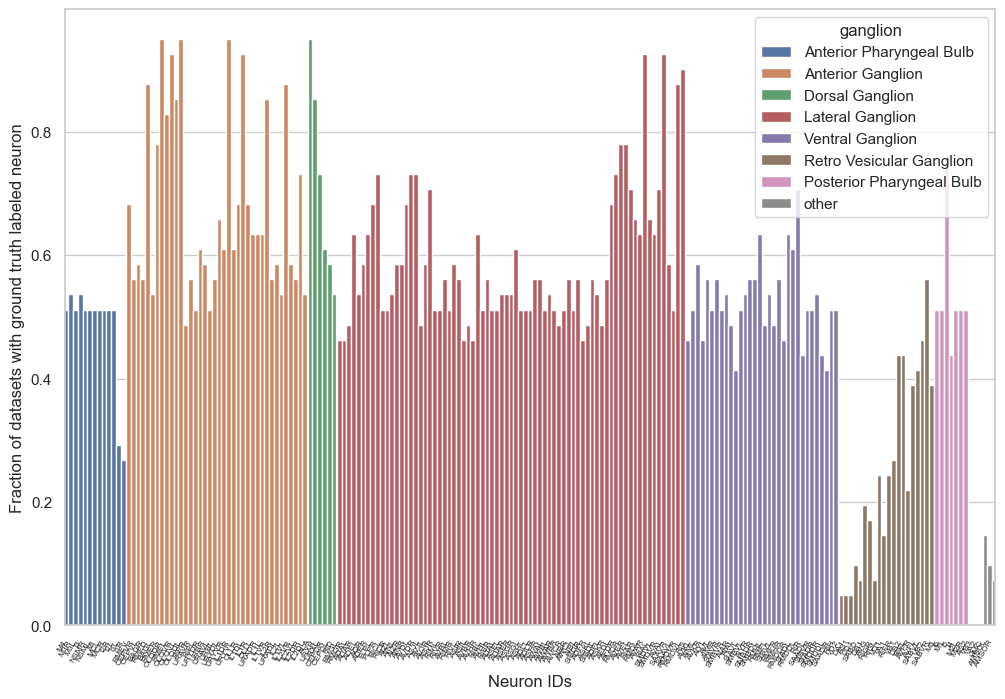

In [273]:
neurons, num = get_neur_nums(tot_dataset, atlas)
plot_neur_nums(neurons, num, atlas)

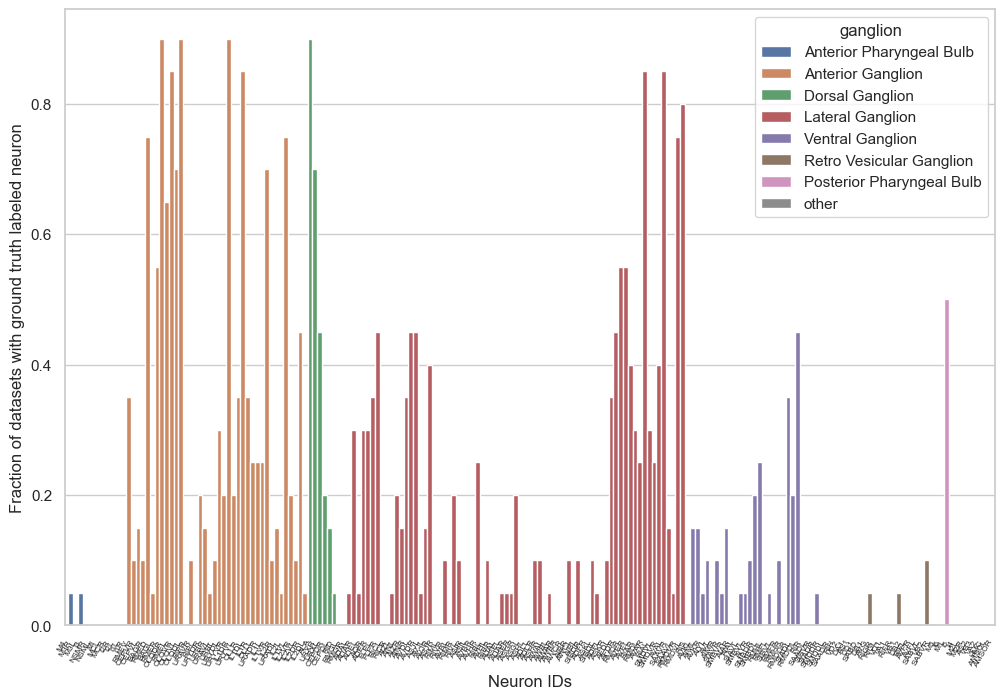

In [274]:
neurons, num = get_neur_nums(FOCO_dataset, atlas)
plot_neur_nums(neurons, num, atlas)

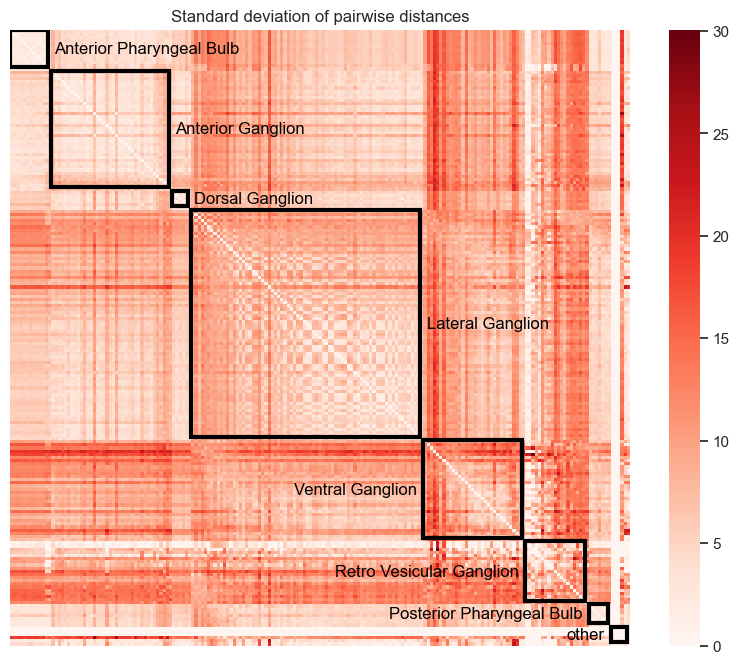

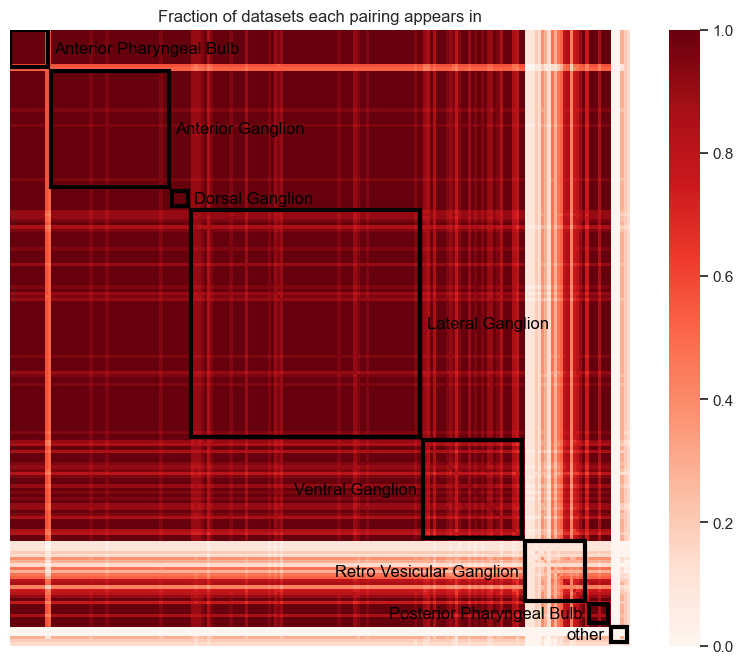

In [275]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_yem, df, 21)
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

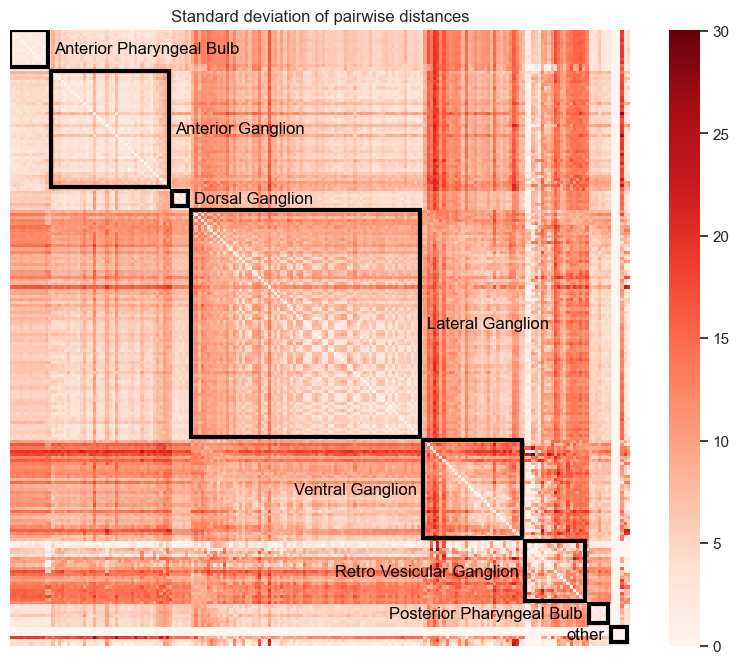

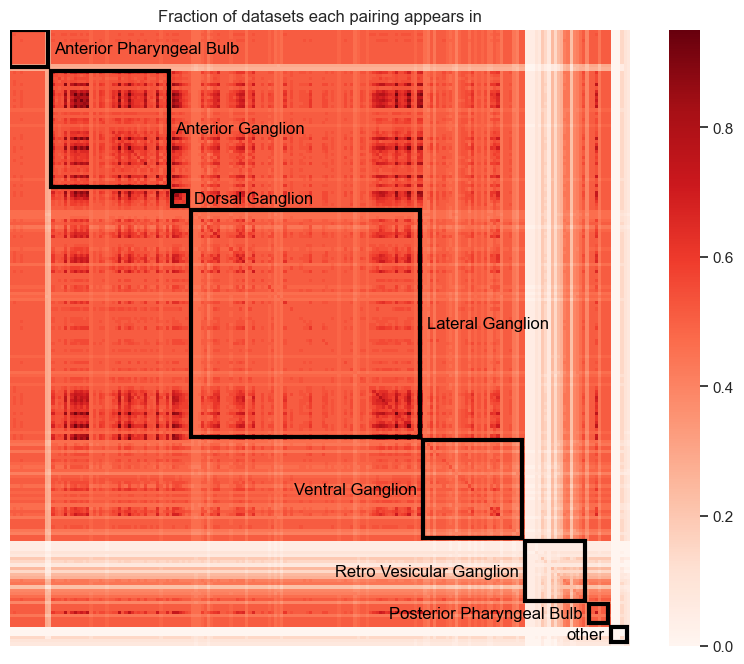

In [276]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_tot, df, len(Yem_dataset.keys())+len(FOCO_dataset.keys()))
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

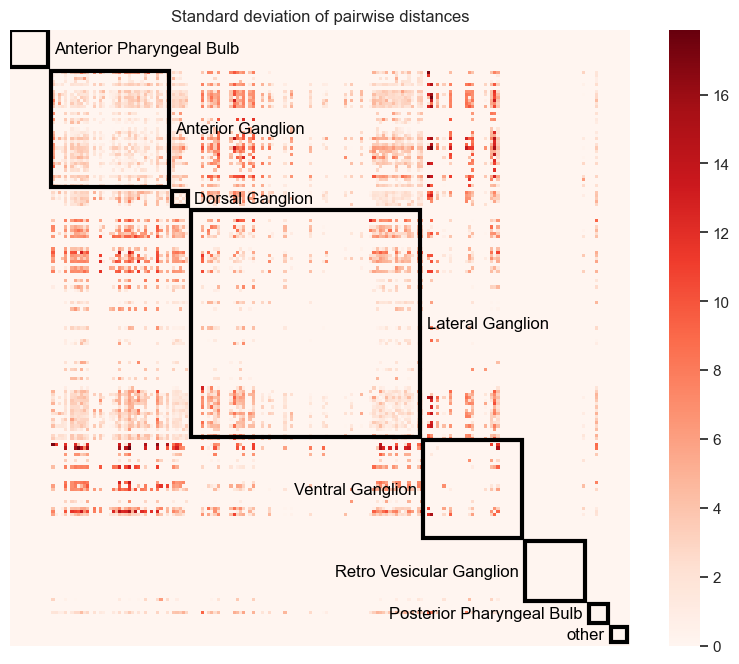

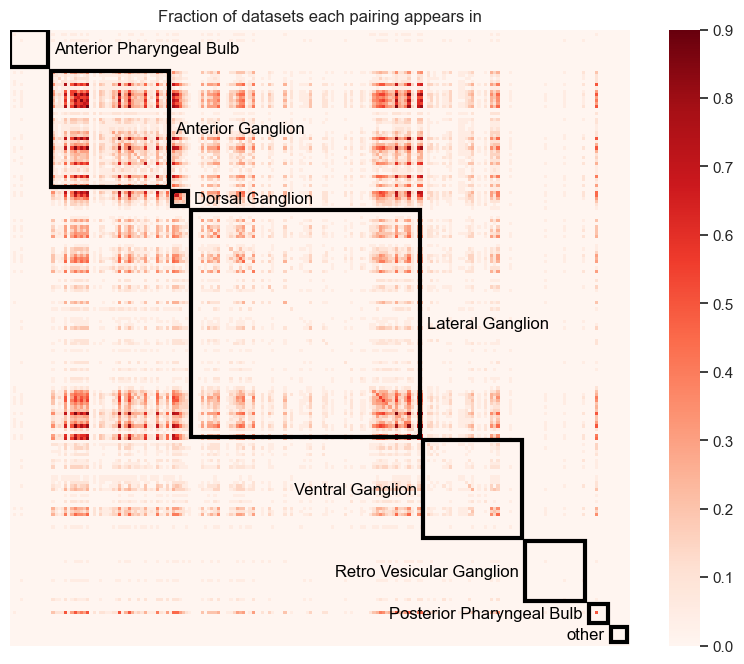

In [277]:
num_pair, num_heatmap, std_heatmap = analyze_pairs(pair_FOCO, df, len(FOCO_dataset.keys()))
plot_std_heatmap(num_heatmap, std_heatmap, df)
plot_num_heatmap(num_heatmap, df)

In [280]:
tot_dataset['20190928_08']

,x,y,z,R,G,B,xr,yr,zr,ID
0,18,100,10,492,968,1153,4.800000,26.666667,15.0,I1R
1,22,133,12,581,931,1261,5.866667,35.466667,18.0,I1L
2,76,85,6,544,114,467,20.266667,22.666667,9.0,I2R
3,78,166,12,565,113,462,20.800000,44.266667,18.0,I2L
4,79,86,18,480,0,333,21.066667,22.933333,27.0,MI
...,...,...,...,...,...,...,...,...,...,...
178,485,179,5,358,1046,1013,129.333333,47.733333,7.5,DD1
179,493,188,5,137,258,1320,131.466667,50.133333,7.5,VD1
180,500,180,7,150,194,514,133.333333,48.000000,10.5,RIGR
181,500,170,5,127,803,362,133.333333,45.333333,7.5,AVG


In [300]:
atlas.df
print(np.asarray(atlas.df['ganglion']))

['Anterior Pharyngeal Bulb' 'Anterior Pharyngeal Bulb'
 'Anterior Pharyngeal Bulb' 'Anterior Pharyngeal Bulb'
 'Anterior Pharyngeal Bulb' 'Anterior Pharyngeal Bulb'
 'Anterior Pharyngeal Bulb' 'Anterior Pharyngeal Bulb'
 'Anterior Pharyngeal Bulb' 'Anterior Pharyngeal Bulb'
 'Anterior Pharyngeal Bulb' 'Anterior Pharyngeal Bulb'
 'Anterior Pharyngeal Bulb' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ganglion'
 'Anterior Ganglion' 'Anterior Ganglion' 'Anterior Ga

In [302]:
x = [5,2,4]

if 3 in x:
    print(x)


In [335]:
def get_ganglia_variance(atlas_df, pairs, num_neighbors):

    ganglia = {}
    visited_pair = []
    X = np.asarray(atlas_df[['X','Y','Z']])
    neighbors = NearestNeighbors(n_neighbors=num_neighbors, algorithm='auto')

    neighbors.fit(X)

    neighbor_dists, neighbor_index = neighbors.kneighbors(X=X, return_distance = True)

    for i, row in atlas_df.iterrows():
        neighbors = neighbor_index[i,1:]
        neighb_dists = neighbor_dists[i, 1:]
        ID = row['ID']
        ganglion = row['ganglion']
        for j, neighbor in enumerate(neighbors):
            n_ID = atlas_df.loc[neighbor, 'ID']
            n_gang = atlas_df.loc[neighbor, 'ganglion']
            if ganglion < n_gang:
                gang_pair = ganglion + '-' + n_gang
            else:
                gang_pair = n_gang + '-' + ganglion


            if ID == n_ID:
                break
            
            elif ID < n_ID:
                pair = ID + '-' + n_ID
            else:
                pair = n_ID + '-' + ID

            if pair in pairs.keys() and pair not in visited_pair:
                pair_dists = pairs[pair]
                pair_std = np.std(pair_dists)

                if not gang_pair in ganglia.keys():
                    ganglia[gang_pair] = [pair_std]
                else:
                    ganglia[gang_pair].append(pair_std)

                visited_pair.append(pair)

    return ganglia

ganglia = get_ganglia_variance(atlas.df, pair_tot, 10)

['I3-M4', 'IL2DL-M4', 'IL2DR-M4', 'M4-MI', 'M3R-M4', 'M4-URADL', 'M3L-M4', 'IL1DL-M4', 'M4-URADR', 'M3R-NSMR', 'IL2VR-M3R', 'M3L-M3R', 'IL1VR-M3R', 'M3R-MCR', 'IL2VL-M3R', 'IL1R-M3R', 'IL2DR-M3R', 'IL2VL-M3L', 'M3L-NSML', 'IL2DL-M3L', 'IL1VL-M3L', 'M3L-MCL', 'IL1L-M3L', 'IL2L-M3L', 'I3-MI', 'I3-IL2DL', 'I3-IL2DR', 'I3-M3R', 'I3-MCR', 'I3-MCL', 'I3-M3L', 'I3-NSMR', 'I2R-NSMR', 'MCR-NSMR', 'MCL-NSMR', 'MI-NSMR', 'M4-NSMR', 'M3L-NSMR', 'IL2VR-NSMR', 'I2L-NSML', 'MCL-NSML', 'IL2VL-NSML', 'MCR-NSML', 'IL2DL-NSML', 'M3R-NSML', 'I3-NSML', 'NSML-NSMR', 'IL2DL-MI', 'MCR-MI', 'MCL-MI', 'IL2DR-MI', 'M3R-MI', 'M3L-MI', 'I2L-MCL', 'MCL-MCR', 'I2R-MCL', 'M3R-MCL', 'I2R-MCR', 'I2L-MCR', 'M3L-MCR', 'I2R-M3R', 'I2R-I3', 'I2R-MI', 'I2L-I2R', 'I2R-NSML', 'I2R-M3L', 'I2L-M3L', 'I2L-IL2VL', 'I1L-I2L', 'AMSOL-I2L', 'I2L-NSMR', 'AMSOL-I1L', 'I1L-I1R', 'AMSOR-I1L', 'I1L-MCL', 'I1L-MCR', 'I1L-NSML', 'I1L-I2R', 'I1L-MI', 'AMSOR-I1R', 'AMSOL-I1R', 'I1R-MCR', 'I1R-I2R', 'I1R-MCL', 'I1R-I2L', 'I1R-NSMR', 'I1R-NSML

            abbrev                 ganglion1                 ganglion2  \
0  AntBulb-AntBulb  Anterior Pharyngeal Bulb  Anterior Pharyngeal Bulb   
1  AntBulb-AntBulb  Anterior Pharyngeal Bulb  Anterior Pharyngeal Bulb   
2  AntBulb-AntBulb  Anterior Pharyngeal Bulb  Anterior Pharyngeal Bulb   
3  AntBulb-AntBulb  Anterior Pharyngeal Bulb  Anterior Pharyngeal Bulb   
4  AntBulb-AntBulb  Anterior Pharyngeal Bulb  Anterior Pharyngeal Bulb   

      value  intra  
0  1.094766   True  
1  1.436496   True  
2  1.059599   True  
3  1.143029   True  
4  2.143282   True  


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/gk/6ffbr8g11tqbyqmft2vx0y5h0000gn/T/ipykernel_39192/3700435405.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 2000x600 with 0 Axes>

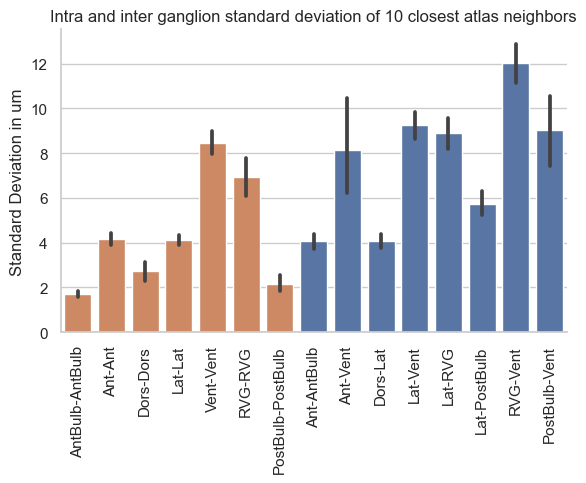

In [355]:
def plot_ganglion_variance(ganglia):

    abbrevs = {'Anterior Pharyngeal Bulb':'AntBulb', 'Anterior Ganglion':'Ant', 'Dorsal Ganglion':'Dors', 'Lateral Ganglion':'Lat', 'Ventral Ganglion':'Vent', 'Retro Vesicular Ganglion':'RVG', 'Posterior Pharyngeal Bulb':'PostBulb','other':'Oth'}
    order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Vent','Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent']

    data = {'abbrev':[], 'ganglion1':[], 'ganglion2':[], 'value':[], 'intra':[]}

    for key,values in ganglia.items():
        ganglion1, ganglion2 = key.split('-')

        if len(values)<5:
            continue

        for value in values:
            if ganglion1 =='other' or ganglion2 =='other':
                continue
            data['abbrev'].append(abbrevs[ganglion1] + '-' +abbrevs[ganglion2])
            data['ganglion1'].append(ganglion1)
            data['ganglion2'].append(ganglion2)
            data['value'].append(value)
            data['intra'].append(ganglion1 == ganglion2)



    df = pd.DataFrame(data)
    
    print(df.head())

    sns.set(style='whitegrid')
    fig = plt.figure(figsize=(20,6))

    g = sns.catplot(data= df, order=order, kind='bar', x='abbrev', y='value', hue='intra', dodge=False)

    plt.ylabel('Standard Deviation in um')
    plt.xlabel(None)
    plt.xticks(rotation='vertical')
    plt.title('Intra and inter ganglion standard deviation of 10 closest atlas neighbors')
    g._legend.remove()
    plt.tight_layout()
    plt.show()

plot_ganglion_variance(ganglia)    

In [ ]:
order = ['AntBulb-AntBulb', 'Ant-Ant', 'Dors-Dors', 'Lat-Lat', 'Vent-Vent', 'RVG-RVG', 'PostBulb-PostBulb', 'Ant-AntBulb', 'Ant-Dors', 'Ant-Lat', 'Dors-Lat', 'Lat-Vent','Lat-RVG','Lat-PostBulb', 'RVG-Vent', 'PostBulb-Vent','Postbulb-RVG']

In [344]:
df = pd.DataFrame()

for key, value in sorted(ganglia.items()):
    print(key)
    print(len(value))

Anterior Ganglion-Anterior Ganglion
191
Anterior Ganglion-Anterior Pharyngeal Bulb
23
Anterior Ganglion-Dorsal Ganglion
1
Anterior Ganglion-Lateral Ganglion
1
Anterior Ganglion-Ventral Ganglion
9
Anterior Pharyngeal Bulb-Anterior Pharyngeal Bulb
59
Anterior Pharyngeal Bulb-other
16
Dorsal Ganglion-Dorsal Ganglion
11
Dorsal Ganglion-Lateral Ganglion
26
Dorsal Ganglion-other
5
Lateral Ganglion-Lateral Ganglion
312
Lateral Ganglion-Posterior Pharyngeal Bulb
41
Lateral Ganglion-Retro Vesicular Ganglion
27
Lateral Ganglion-Ventral Ganglion
53
Lateral Ganglion-other
5
Posterior Pharyngeal Bulb-Posterior Pharyngeal Bulb
11
Posterior Pharyngeal Bulb-Retro Vesicular Ganglion
1
Posterior Pharyngeal Bulb-Ventral Ganglion
12
Retro Vesicular Ganglion-Retro Vesicular Ganglion
82
Retro Vesicular Ganglion-Ventral Ganglion
22
Ventral Ganglion-Ventral Ganglion
135
other-other
1


In [293]:
pair_tot.keys()

dict_keys(['I1R-I1R', 'I1R-I1L', 'I1L-I1R', 'I1R-I2R', 'I2R-I1R', 'I1R-I2L', 'I2L-I1R', 'I1R-MI', 'MI-I1R', 'I1R-MCR', 'MCR-I1R', 'I1R-MCL', 'MCL-I1R', 'I1R-I3', 'I3-I1R', 'I1R-NSMR', 'NSMR-I1R', 'I1R-NSML', 'NSML-I1R', 'I1R-IL2VR', 'IL2VR-I1R', 'I1R-IL2DR', 'IL2DR-I1R', 'I1R-IL2DL', 'IL2DL-I1R', 'I1R-M4', 'M4-I1R', 'I1R-IL2R', 'IL2R-I1R', 'I1R-URADL', 'URADL-I1R', 'I1R-M3R', 'M3R-I1R', 'I1R-URADR', 'URADR-I1R', 'I1R-IL2VL', 'IL2VL-I1R', 'I1R-IL2L', 'IL2L-I1R', 'I1R-M3L', 'M3L-I1R', 'I1R-OLLL', 'OLLL-I1R', 'I1R-OLLR', 'OLLR-I1R', 'I1R-URYVL', 'URYVL-I1R', 'I1R-IL1R', 'IL1R-I1R', 'I1R-IL1DL', 'IL1DL-I1R', 'I1R-URYDL', 'URYDL-I1R', 'I1R-IL1L', 'IL1L-I1R', 'I1R-IL1DR', 'IL1DR-I1R', 'I1R-IL1VR', 'IL1VR-I1R', 'I1R-URBR', 'URBR-I1R', 'I1R-URAVL', 'URAVL-I1R', 'I1R-URYDR', 'URYDR-I1R', 'I1R-OLQDR', 'OLQDR-I1R', 'I1R-URYVR', 'URYVR-I1R', 'I1R-RIPL', 'RIPL-I1R', 'I1R-URBL', 'URBL-I1R', 'I1R-OLQDL', 'OLQDL-I1R', 'I1R-RIPR', 'RIPR-I1R', 'I1R-OLQVL', 'OLQVL-I1R', 'I1R-BAGR', 'BAGR-I1R', 'I1R-RMED'

195
195


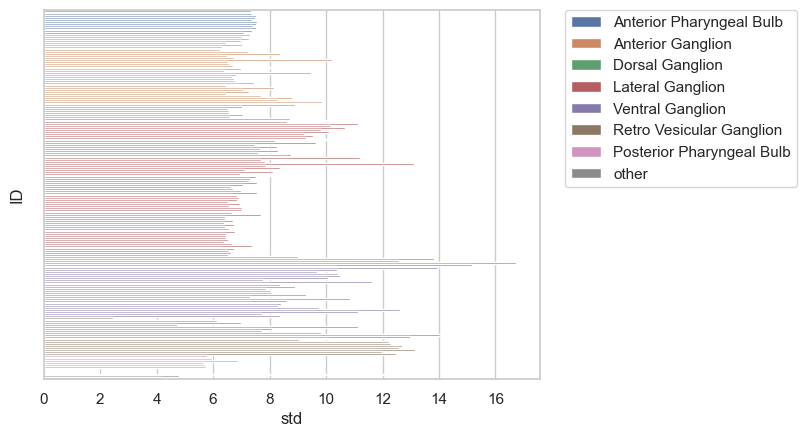

In [177]:
def plot_sum_heatmap(heatmap,df):

    avg_std = np.sum(heatmap,axis=0)/heatmap.shape[0]

    new_df = df.copy()

    new_df['std'] = avg_std
    print(len(avg_std))
    print(len(np.asarray(new_df['ganglion'])))

    bar = sns.barplot(data=new_df, y='ID', x='std', hue='ganglion', orient='h', dodge=False, width=1.0)

    bar.set(yticklabels=[])

    #plt.legend([],[], frameon=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.show()
    

plot_sum_heatmap(std_heatmap, df)

In [162]:
np.asarray(df['ganglion'])

array(['Anterior Pharyngeal Bulb', 'Anterior Pharyngeal Bulb',
       'Anterior Pharyngeal Bulb', 'Anterior Pharyngeal Bulb',
       'Anterior Pharyngeal Bulb', 'Anterior Pharyngeal Bulb',
       'Anterior Pharyngeal Bulb', 'Anterior Pharyngeal Bulb',
       'Anterior Pharyngeal Bulb', 'Anterior Pharyngeal Bulb',
       'Anterior Pharyngeal Bulb', 'Anterior Pharyngeal Bulb',
       'Anterior Pharyngeal Bulb', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
       'Anterior Ganglion', 'Anterior Ganglion', 'Anterior Ganglion',
      

### Color statistics of datasets

In [14]:
def get_color_stats(folder):

    rgbhist = np.zeros((32,3))

    neur_colors = {}

    for file in os.listdir(folder):
        if not file[-4:] == '.nwb':
            continue

        print(file)

        blobs, rgb_data = get_nwb_neurons(folder+'/'+file)

        color_norm = (rgb_data - np.min(rgb_data, axis=(0,1,2))) / (np.max(rgb_data, axis=(0,1,2))- np.min(rgb_data, axis=(0,1,2)))

        blobs[['Rnorm', 'Gnorm','Bnorm']] = np.nan

        for i, row in blobs.iterrows():
            colors = color_norm[max(row['x']-2,0):min(row['x']+2,rgb_data.shape[0]-1),max(row['y']-2,0):min(row['y']+2,rgb_data.shape[1]-1),max(row['z']-1,0):min(row['z']+1,rgb_data.shape[2]-1),:]

            flat_colors = colors.reshape(-1, colors.shape[-1])
            
            Rnorm = np.median(flat_colors[0])
            Gnorm = np.median(flat_colors[1])
            Bnorm = np.median(flat_colors[2])

            blobs.loc[i, 'Rnorm'] = Rnorm
            blobs.loc[i, 'Gnorm'] = Gnorm
            blobs.loc[i, 'Bnorm'] = Bnorm

        IDd = blobs[blobs['ID']!='']

        for i, row in IDd.iterrows():
            ID = row['ID']
            colors = np.asarray(row[['Rnorm', 'Gnorm', 'Bnorm']])
            if not ID in neur_colors:
                neur_colors[ID] = [colors]
            else:
                neur_colors[ID].append(colors)
            
        image = np.asarray(color_norm)
        im_flat = image.reshape(-1, image.shape[-1])

        rhist, bins = np.histogram(im_flat[:,0], bins=32, range=(0,1))
        ghist, bins = np.histogram(im_flat[:,1], bins=32, range=(0,1))
        bhist, bins = np.histogram(im_flat[:,2], bins=32, range=(0,1))

        rgbhist[:,0] += rhist
        rgbhist[:,1] += ghist
        rgbhist[:,2] += bhist
    
    rgbhist[:,0] = rgbhist[:,0]/np.sum(rgbhist[:,0])
    rgbhist[:,1] = rgbhist[:,1]/np.sum(rgbhist[:,1])
    rgbhist[:,2] = rgbhist[:,2]/np.sum(rgbhist[:,2])

    return rgbhist, neur_colors

In [15]:
foco_rgb, foco_colors = get_color_stats('/Users/danielysprague/foco_lab/data/NWB_Ray')
yem_rgb, yem_colors = get_color_stats('/Users/danielysprague/foco_lab/data/Yemini_NWB')


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


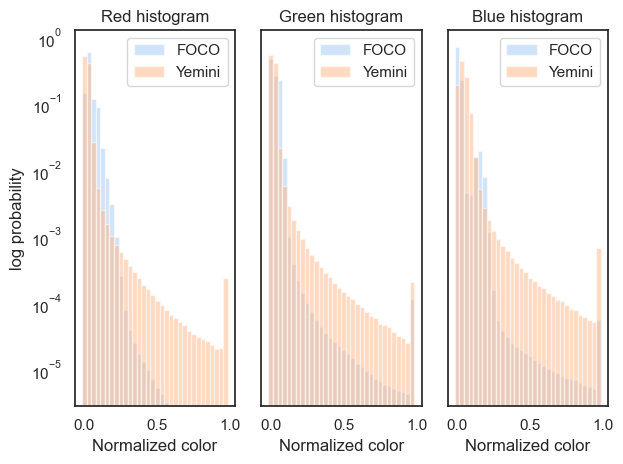

In [16]:
def plot_histograms(dataset_rgbs, labels):

    sns.set(style="white")
    fig, axs = plt.subplots(1,3, sharey=True)

    # Plot the bars using Matplotlib

    bin_edges = np.arange(32)/32

    for i, ax in enumerate(axs):
        #ax.hist(im_flat[:,i], bins= np.arange(32)/32, color= 'red')
        for j, dataset in enumerate(dataset_rgbs):
            ax.bar(bin_edges[:], dataset[:,i], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[j], log=True, label=labels[j])
            #ax.bar(bin_edges[:], yem_rgb[:,0], alpha=0.5, align='center', width=1/32, color=sns.color_palette("pastel")[1], log=True, label='Yemini')
        ax.legend()
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(foco_rgb[:,i]), bins= np.arange(32)/32, alpha=0.3, stat = 'probability', log_scale=(False,True), label='FOCO')
        #sns.histplot(ax=ax, data=np.ones(32),weights=np.transpose(yem_rgb[:,i]), bins=np.arange(32)/32, alpha=0.3, stat = 'probability',log_scale=(False,True), label='Yemini')

    axs[0].set_title('Red histogram')
    axs[0].set_xlabel('Normalized color')
    axs[0].set_ylabel('log probability')
    axs[1].set_title('Green histogram')
    axs[1].set_xlabel('Normalized color')
    axs[2].set_title('Blue histogram')
    axs[2].set_xlabel('Normalized color')

    plt.tight_layout()
    plt.show()

plot_histograms([foco_rgb, yem_rgb], ['FOCO', 'Yemini'])

In [17]:
color_discrim_FOCO = get_color_discrim('/Users/danielysprague/foco_lab/data/NWB_Ray', 6)
color_discrim_Yemini = get_color_discrim('/Users/danielysprague/foco_lab/data/Yemini_NWB', 6)


20230412-20-15-17.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-14-24-57.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-13-25-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-22-43-03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-47-31.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-12-56-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-00-09.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-20-16-50.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221028-18-48-00.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-13-32-08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-16-36-46.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-33-51.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-15-49-47.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-20-02-49.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-21-41-10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221106-21-23-19.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230506-15-01-45.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230510-12-53-34.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20221215-22-02-55.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20230322-18-57-04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190925_04.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191030_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190929_06.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_10.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20191104_08.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_01.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_03.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190924_02.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_13.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_07.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_11.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


20190928_05.nwb


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


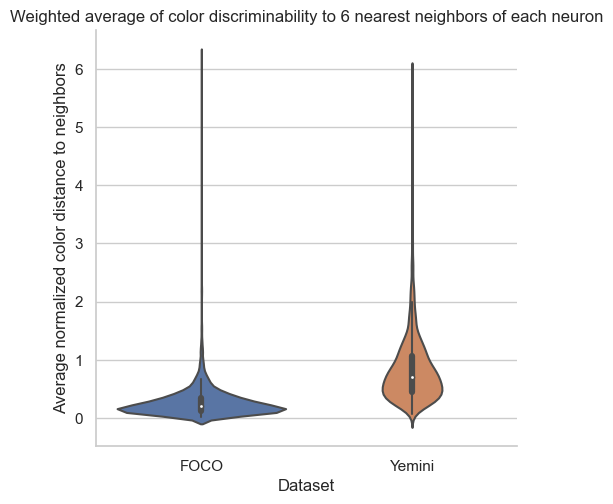

In [18]:
plot_color_discrim([color_discrim_FOCO, color_discrim_Yemini], ['FOCO', 'Yemini'])

## Figure 4: Benchmarking performance of consolidated datasets 

All experiments run using consolidated dataset, different image processing approaches, box-whisker plot similar to above

In [45]:
with NWBHDF5IO('/Users/danielysprague/foco_lab/data/Yemini_NWB/20190924_01.nwb', mode='r', load_namespaces=True) as io:
        read_nwb = io.read()
        seg = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons'].voxel_mask[:]
        labels = read_nwb.processing['NeuroPAL']['NeuroPALSegmentation']['NeuroPALNeurons']['ID_labels'][:]
        channels = read_nwb.acquisition['NeuroPALImageRaw'].RGBW_channels[:] #get which channels of the image correspond to which RGBW pseudocolors
        image = read_nwb.acquisition['NeuroPALImageRaw'].data[:]
        scale = read_nwb.imaging_planes['NeuroPALImVol'].grid_spacing[:] #get which channels of the image correspond to which RGBW pseudocolors

print(scale)

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'ndx-multichannel-volume' version 0.1.7 because version 0.1.9 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


[0.26666667 0.26666667 1.5       ]


In [225]:
def get_accuracy(df, results, LR= False, atlas=None):
    if not LR:
        IDd = df.loc[df['ID']!='',:]
        corr1 = df.loc[df['ID']==results['autoID_1']]
        corr2 = df.loc[df['ID']==results['autoID_2']]
        corr3 = df.loc[df['ID']==results['autoID_3']]
        corr4 = df.loc[df['ID']==results['autoID_4']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)

        per_ID = len(IDd.index)/len(df.index)
        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)

    else:
        atlas_df = atlas.get_df()

        df = pd.merge(df, atlas_df[['ID', 'neuron_class']], on='ID', how='left')

        merged_df = pd.merge(results, atlas_df[['ID', 'neuron_class']], left_on='autoID_1', right_on='ID', how='left')
        merged_df.rename(columns={'neuron_class': 'auto_class_1'}, inplace=True)
        merged_df.drop('ID', axis=1, inplace=True)

        merged_df = pd.merge(merged_df, atlas_df[['ID', 'neuron_class']], left_on='autoID_2', right_on='ID', how='left')
        merged_df.rename(columns={'neuron_class': 'auto_class_2'}, inplace=True)
        merged_df.drop('ID', axis=1, inplace=True)

        merged_df = pd.merge(merged_df, atlas_df[['ID', 'neuron_class']], left_on='autoID_3', right_on='ID', how='left')
        merged_df.rename(columns={'neuron_class': 'auto_class_3'}, inplace=True)
        merged_df.drop('ID', axis=1, inplace=True)

        # Merging for ID_4
        merged_df = pd.merge(merged_df, atlas_df[['ID', 'neuron_class']], left_on='autoID_4', right_on='ID', how='left')
        merged_df.rename(columns={'neuron_class': 'auto_class_4'}, inplace=True)
        merged_df.drop('ID', axis=1, inplace=True)

        IDd = df.loc[df['ID']!='',:]
        corr1 = df.loc[df['neuron_class']==merged_df['auto_class_1']]
        corr2 = df.loc[df['neuron_class']==merged_df['auto_class_2']]
        corr3 = df.loc[df['neuron_class']==merged_df['auto_class_3']]
        corr4 = df.loc[df['neuron_class']==merged_df['auto_class_4']]
            
        corr_cum_2 = pd.concat([corr1,corr2]).drop_duplicates().reset_index(drop=True)
        corr_cum_3 = pd.concat([corr_cum_2,corr3]).drop_duplicates().reset_index(drop=True)
        corr_cum_4 = pd.concat([corr_cum_3,corr4]).drop_duplicates().reset_index(drop=True)

        per_ID = len(IDd.index)/len(df.index)
        per_corr_1 = len(corr1.index)/len(IDd.index)
        per_corr_2 = len(corr_cum_2.index)/len(IDd.index)
        per_corr_3 = len(corr_cum_3.index)/len(IDd.index)
        per_corr_4 = len(corr_cum_4.index)/len(IDd.index)

    return IDd, per_ID, [per_corr_1, per_corr_2, per_corr_3, per_corr_4]

In [84]:
atlas_df = atlas.get_df()
atlas_df

gt = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_paper/all/11_YAaLR.csv', skiprows=7)
gt = gt.rename(columns={'User ID':'ID'})
autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/11_YAaLR.csv')

merged_df = pd.merge(gt, atlas_df[['ID', 'neuron_class']], on='ID', how='left')

merged_df.head()

,ID,User Confidence,Emphasized?,Auto ID,Auto Confidence,Unnamed: 5,Real X (um),Real Y (um),Real Z (um),Unnamed: 9,Z-Scored Red,Z-Scored Green,Z-Scored Blue,Z-Scored White,Unnamed: 14,Estimated GFP,Max GFP,Normalized GFP,Unnamed: 18,neuron_class
0,I1R,1.0,0,NaN,NaN,NaN,18.336782,20.794996,15.750000,NaN,6.044556,7.954885,10.833543,12.396418,NaN,21554.384615,22530.0,1738.759089,NaN,I1
1,I1L,1.0,0,NaN,NaN,NaN,21.379345,20.341513,21.750000,NaN,9.740729,18.229802,18.862395,12.439850,NaN,19731.692308,21061.0,1586.167972,NaN,I1
2,AMSOL,1.0,0,NaN,NaN,NaN,24.907975,9.963190,24.750000,NaN,2.982248,14.802994,0.359120,9.707879,NaN,20621.846154,21386.0,2124.238120,NaN,AMSO
3,I2R,1.0,0,NaN,NaN,NaN,33.666744,24.509281,11.683901,NaN,12.925403,2.693210,3.037950,12.439850,NaN,18596.692308,19243.0,1494.928932,NaN,I2
4,I2L,1.0,0,NaN,NaN,NaN,33.956429,22.916969,24.353949,NaN,17.382137,3.397190,7.285318,12.439850,NaN,20084.538462,20771.0,1614.532151,NaN,I2


In [43]:
IDd, per_ID, accs = get_accuracy(Yem_dataset['20190928_03'], pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_NWB_results/20190928_03.nwb.csv'))
print(accs[0])
print(accs[1])
print(accs[2])
print(accs[3])

0.023809523809523808
0.03571428571428571
0.041666666666666664
0.05357142857142857


In [106]:
gt = pd.read_csv('/Users/danielysprague/foco_lab/data/NP_paper/all/70_YApLR.csv', skiprows=7)
gt = gt.rename(columns={'User ID':'ID'})
autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/70_YApLR.csv')

IDd, per_ID, accs = get_accuracy(gt, autID, LR=True, atlas=atlas)
print(accs)

[0.0, 0.0, 0.0, 0.0]


38_YAaDV.csv
0.9368421052631579
56_YAaDV.csv
0.9162303664921466
64_YAaDV.csv
0.91005291005291
11_YAaLR.csv
0.9015544041450777
76_YAaDV.csv
0.9308510638297872
20_YAaLR.csv
0.8341968911917098
62_YAaLR.csv
0.3870967741935484
7_YAaLR.csv
0.898936170212766
55_YAaDV.csv
0.953125
70_YAaLR.csv
0.9481865284974094


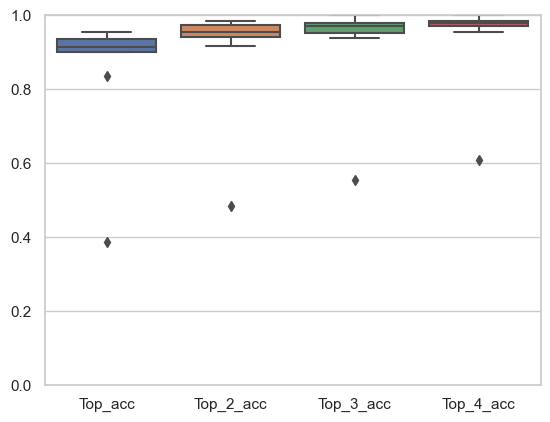

In [178]:
def plot_accuracy_paper(folder,atlas):

    all_accs = None

    for file in os.listdir(folder):

        if file[-4:]=='.csv' and file[-7]=='a':
            gt = pd.read_csv(folder+'/'+file, skiprows=7)
            gt = gt.rename(columns={'User ID':'ID'})
            autID = pd.read_csv('/Users/danielysprague/foco_lab/data/Yemini_paper_results/'+file)

            IDd, per_ID, accs = get_accuracy(gt, autID, LR=True, atlas=atlas)

            print(file)
            print(accs[0])

            if all_accs is None:
                all_accs = np.asarray(accs)

            else:
                all_accs = np.vstack((all_accs, accs))

        else:
            continue

    df = pd.DataFrame(all_accs, columns=['Top_acc', 'Top_2_acc', 'Top_3_acc', 'Top_4_acc'])

    sns.boxplot(data=df, orient='v')

    plt.ylim((0,1))

    plt.show()

    return df


df = plot_accuracy_paper('/Users/danielysprague/foco_lab/data/NP_paper/all', atlas)

In [192]:
old_FOCO_dataset = get_dataset_neurons('/Users/danielysprague/foco_lab/data/NWB_foco')

/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NWB-dev/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cache

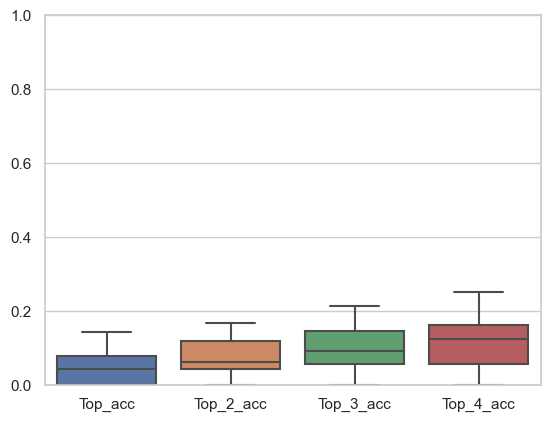

In [241]:
def plot_accuracy(dataset, csv_folder, atlas):

    all_accs = np.zeros((len(dataset), 4))

    for i, key in enumerate(dataset.keys()):
        csv_nwb = csv_folder+key+'.csv'
        IDd, per_ID, accs = get_accuracy(dataset[key], pd.read_csv(csv_nwb), LR=True, atlas=atlas)

        all_accs[i,:4] = np.transpose(np.asarray(accs))

    df = pd.DataFrame(all_accs, columns=['Top_acc', 'Top_2_acc', 'Top_3_acc', 'Top_4_acc'])

    sns.boxplot(data=df, orient='v')

    plt.ylim((0,1))

    plt.show()

    return df

df = plot_accuracy(FOCO_dataset, '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', atlas)

    
        

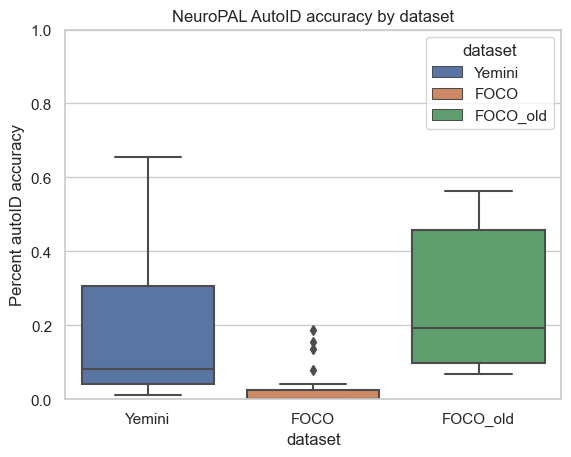

In [363]:
def plot_accuracies(datasets, csv_folders, labels, LR=False, atlas=None, title = 'Accuracy by dataset'):

    num_data_total = np.sum([len(dataset.keys()) for dataset in datasets])

    accs = np.empty((num_data_total, 6), dtype='O')

    k=0

    for i, dataset in enumerate(datasets):
        csv_folder = csv_folders[i]
        label = labels[i]
        for j, key in enumerate(dataset.keys()):
            csv = csv_folder + key +'.csv'
            IDd, per_ID, acc = get_accuracy(dataset[key], pd.read_csv(csv), LR=LR, atlas=atlas)
            acc.append(label)
            acc.append(key)
            accs[k,:] = acc
            k+=1

    df = pd.DataFrame(accs, columns = ['top_acc', 'top_2_acc', 'top_3_acc', 'top_4_acc', 'dataset', 'identifier'])

    sns.boxplot(data=df, x = 'dataset', y='top_acc', hue='dataset', orient='v', dodge=False)

    plt.ylabel('Percent autoID accuracy')
    plt.ylim((0,1))

    plt.title('NeuroPAL AutoID accuracy by dataset')

    plt.show()

    return df

acc_df = plot_accuracies([Yem_dataset, FOCO_dataset, old_FOCO_dataset], ['/Users/danielysprague/foco_lab/data/Yemini_NWB_results/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results/', '/Users/danielysprague/foco_lab/data/NWB_foco_results/'], ['Yemini', 'FOCO', 'FOCO_old'])

    

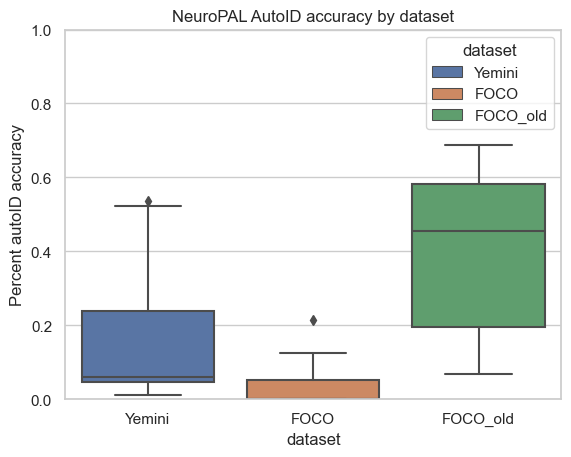

In [365]:
def plot_accuracies(datasets, csv_folders, labels, LR=False, atlas=None, title = 'Accuracy by dataset'):

    num_data_total = np.sum([len(dataset.keys()) for dataset in datasets])

    accs = np.empty((num_data_total, 6), dtype='O')

    k=0

    for i, dataset in enumerate(datasets):
        csv_folder = csv_folders[i]
        label = labels[i]
        for j, key in enumerate(dataset.keys()):
            csv = csv_folder + key +'.csv'
            IDd, per_ID, acc = get_accuracy(dataset[key], pd.read_csv(csv), LR=LR, atlas=atlas)
            acc.append(label)
            acc.append(key)
            accs[k,:] = acc
            k+=1

    df = pd.DataFrame(accs, columns = ['top_acc', 'top_2_acc', 'top_3_acc', 'top_4_acc', 'dataset', 'identifier'])

    sns.boxplot(data=df, x = 'dataset', y='top_acc', hue='dataset', orient='v', dodge=False)

    plt.ylabel('Percent autoID accuracy')
    plt.ylim((0,1))

    plt.title('NeuroPAL AutoID accuracy by dataset')

    plt.show()

    return df

acc_df = plot_accuracies([Yem_dataset, FOCO_dataset, old_FOCO_dataset], ['/Users/danielysprague/foco_lab/data/Yemini_NWB_results_match/', '/Users/danielysprague/foco_lab/data/NWB_Ray_results_match/', '/Users/danielysprague/foco_lab/data/NWB_foco_results_match/'], ['Yemini', 'FOCO', 'FOCO_old'])

    

In [261]:
acc_df

,top_acc,top_2_acc,top_3_acc,top_4_acc,dataset,identifier
0,0.666667,0.765027,0.830601,0.852459,Yemini,20190928_08
1,0.243902,0.384146,0.469512,0.518293,Yemini,20190929_02
2,0.062857,0.108571,0.125714,0.188571,Yemini,20190929_03
3,0.144444,0.222222,0.277778,0.344444,Yemini,20190925_01
4,0.125714,0.28,0.36,0.44,Yemini,20191030_07
5,0.448864,0.607955,0.676136,0.738636,Yemini,20190925_04
6,0.06044,0.148352,0.21978,0.241758,Yemini,20191030_03
7,0.119048,0.184524,0.220238,0.261905,Yemini,20190929_05
8,0.085227,0.142045,0.193182,0.25,Yemini,20190929_07
9,0.04,0.102857,0.154286,0.188571,Yemini,20190929_06


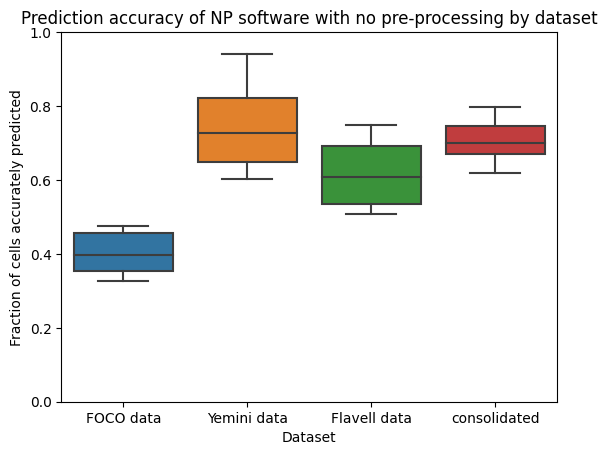

In [10]:
data1 = np.random.rand(10)*(0.5-0.3)+0.3
data1_label = np.asarray(['FOCO data']*10)
data2 = np.random.rand(10)*(0.95-0.6)+0.6
data2_label = np.asarray(['Yemini data']*10)
data3 = np.random.rand(10)*(0.75-0.5)+0.5
data3_label = np.asarray(['Flavell data']*10)
data4 = np.random.rand(10)*(0.8-0.6)+0.6
data4_label = np.asarray(['consolidated']*10)

data = np.hstack((data1,data2,data3,data4))
labels = np.hstack((data1_label, data2_label, data3_label, data4_label))

df = pd.DataFrame({'accuracy':data, 'labels':labels})

sns.boxplot(data = df, x= 'labels', y='accuracy', orient='v')
plt.title('Prediction accuracy of NP software with no pre-processing by dataset')
plt.ylim((0,1))
plt.ylabel('Fraction of cells accurately predicted')
plt.xlabel('Dataset')
#plt.xticks(plt.xticks()[0], ['top 1 run', 'top 5 runs', 'top3 5 runs', 'top5 5 runs', 'top 10 runs', 'top3 10 runs', 'top5 10 runs'], rotation=45)
plt.show()

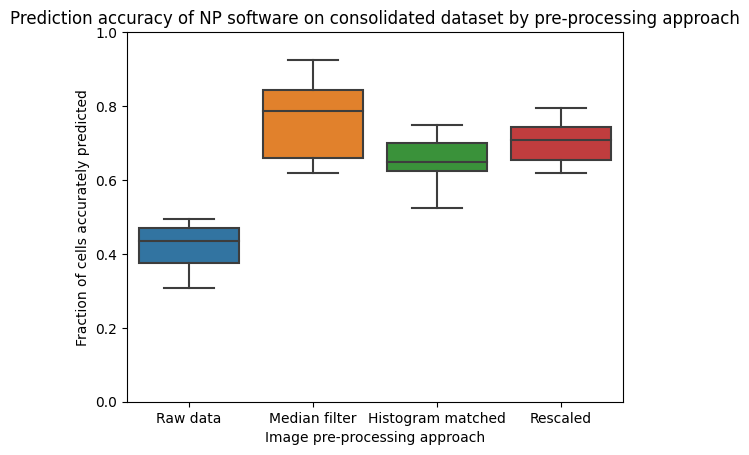

In [12]:
data1 = np.random.rand(10)*(0.5-0.3)+0.3
data1_label = np.asarray(['Raw data']*10)
data2 = np.random.rand(10)*(0.95-0.6)+0.6
data2_label = np.asarray(['Median filter']*10)
data3 = np.random.rand(10)*(0.75-0.5)+0.5
data3_label = np.asarray(['Histogram matched']*10)
data4 = np.random.rand(10)*(0.8-0.6)+0.6
data4_label = np.asarray(['Rescaled']*10)

data = np.hstack((data1,data2,data3,data4))
labels = np.hstack((data1_label, data2_label, data3_label, data4_label))

df = pd.DataFrame({'accuracy':data, 'labels':labels})

sns.boxplot(data = df, x= 'labels', y='accuracy', orient='v')
plt.title('Prediction accuracy of NP software on consolidated dataset by pre-processing approach')
plt.ylim((0,1))
plt.ylabel('Fraction of cells accurately predicted')
plt.xlabel('Image pre-processing approach')
#plt.xticks(plt.xticks()[0], ['top 1 run', 'top 5 runs', 'top3 5 runs', 'top5 5 runs', 'top 10 runs', 'top3 10 runs', 'top5 10 runs'], rotation=45)
plt.show()

## Figure 5: Atlas visualizations - projected color space visualization, unrollled butterfly visualization